To perform statistical analyses to investigate the association between the untargeted neonatal metabolome and storage time of dried blood spot samples. Principal component analysis is used to test if the overall variation among of the metabolite features are associated with storage time. Multiple linear regression models are used to pinpoint metabolite features that are influenced by storage. 

In [1]:
suppressPackageStartupMessages({
library(data.table)
library(tidyverse)
library(openxlsx)
library(ggsci)
library(cowplot)
library(ggrepel)
library(matrixStats)
library(ggpubr)
    })

Warning message:
"package 'openxlsx' was built under R version 3.6.3"Warning message:
"package 'ggsci' was built under R version 3.6.3"Warning message:
"package 'cowplot' was built under R version 3.6.3"Warning message:
"package 'ggrepel' was built under R version 3.6.3"Warning message:
"package 'matrixStats' was built under R version 3.6.3"Warning message:
"package 'ggpubr' was built under R version 3.6.3"

# Import Data

Metabolite Data

In [2]:
metabolites <- read.csv("../output/RAPCA_ImputedData_Rank100_NA_5.tsv",
                        sep = '\t', check.names = F, row.names = 1)

Import Metabolite annotations and merge with metabolite features

In [3]:
metabolite_annotations <- read.csv("../output/annotation_classes.csv")
annotation <- data.frame(rownames(metabolites))
colnames(annotation) <- "id"
annotation <- merge(annotation,metabolite_annotations,by="id",sort=FALSE)

sample_names <- colnames(metabolites)

processed_metabolites <- as.data.frame(t(metabolites))
colnames(processed_metabolites) <- annotation$metabolite_ID

processed_metabolites <- add_column(.data=processed_metabolites,
                                    filename=sample_names,.before=1)

Import Metadata and merge with metabolite data

In [4]:
metadata <- read.xlsx("../data/metadata/Metadata_timsTOF.xlsx")
metadata <- subset(metadata,SampleType=="Sample")

Data <- merge(metadata,processed_metabolites,by="filename")


Data <- Data %>% add_column(storage=2020-Data$year,.before = 10) # Storage variable defined

start <- which(names(Data)=="Glutathionate") # Define start of metabolite dataset

# PCA of metabolite data

Perform PCA with 8 principal components

In [5]:
PCA_mod <- mixOmics::pca(Data[start:ncol(Data)],ncomp=8)

#Plot the explained variance per PC
PCA_variance <- cbind.data.frame(names(PCA_mod$explained_variance[1:8]),PCA_mod$explained_variance[1:8])
colnames(PCA_variance)<- c("PC","ExpVar")

pca_var_plot <- ggplot(PCA_variance,aes(x=PC,y=ExpVar),color=myCol[1])+
  geom_bar(stat = "identity")+
  theme_classic()+
  xlab("Principal Components")+
  ylab("Explained variance (%)")

Scoreplot of the 4 first principal components color by storage time

In [6]:
# Create dataframe with relevant information for scoreplot
pcaplotdata <- cbind.data.frame(Data$storage,PCA_mod$variates$X[,1],PCA_mod$variates$X[,2],
                                PCA_mod$variates$X[,3],PCA_mod$variates$X[,4])
colnames(pcaplotdata) <- c("storage","PC1","PC2","PC3","PC4")
# Define short storage as  1-3 years, medium as 4-7 and long as 7-10
pcaplotdata["storage_group"] <- ifelse(pcaplotdata$storage<4,"short",ifelse(pcaplotdata$storage<7,"medium","long"))

pcascore12 <- ggplot(pcaplotdata,aes(x=PC1,y=PC2, color=as.factor(storage_group)))+
  geom_point()+
  theme_classic()+
  theme(legend.title=element_blank())+
  scale_color_jama()+
  theme(legend.text=element_text(size=14))

pcascore34 <- ggplot(pcaplotdata,aes(x=PC3,y=PC4, color=as.factor(storage_group)))+
  geom_point()+
  theme_classic()+
  theme(legend.title=element_blank())+
  scale_color_jama()+
  theme(legend.text=element_text(size=14))

Create boxplots of PC scores

In [7]:
pcabox1 <- ggplot(pcaplotdata,aes(x=as.factor(storage),y=PC1,color=as.factor(storage_group)))+
  geom_boxplot()+
  theme_classic()+
  geom_jitter()+
  xlab("")+
  theme(legend.position ="none")+
  geom_smooth(method="lm")+
  scale_color_jama()

pcabox2 <- ggplot(pcaplotdata,aes(x=as.factor(storage),y=PC2,color=as.factor(storage_group)))+
  geom_boxplot()+
  theme_classic()+
  geom_jitter()+
  xlab("")+
  theme(legend.position ="none")+
  geom_smooth(method="lm")+
  scale_color_jama()

pcabox3 <- ggplot(pcaplotdata,aes(x=as.factor(storage),y=PC3,color=as.factor(storage_group)))+
  geom_boxplot()+
  theme_classic()+
  geom_jitter()+
  xlab("")+
  theme(legend.position ="none")+
  geom_smooth(method="lm")+
  scale_color_jama()

pcabox4 <- ggplot(pcaplotdata,aes(x=as.factor(storage),y=PC4,color=as.factor(storage_group)))+
  geom_boxplot()+
  theme_classic()+
  geom_jitter()+
  xlab("")+
  theme(legend.position ="none")+
  geom_smooth(method="lm")+
  scale_color_jama()

Display all PCA plots

`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'


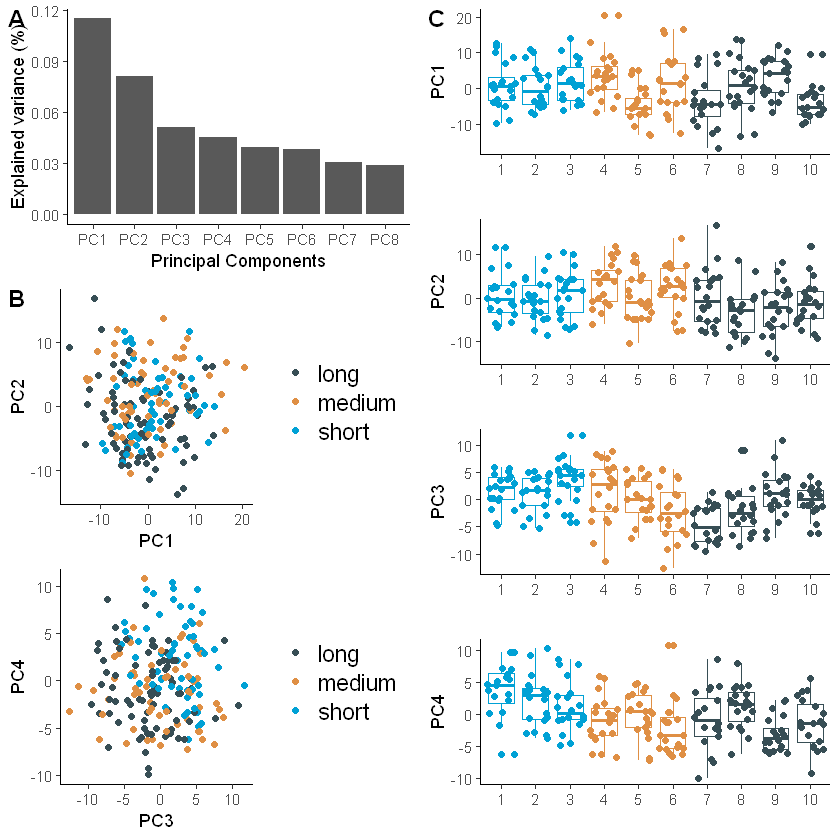

In [8]:
pca_plots <- plot_grid(plot_grid(pca_var_plot,pcascore12,pcascore34, nrow=3,ncol=1,labels=c("A","B","")),
          plot_grid(pcabox1,pcabox2,pcabox3,pcabox4,ncol=1,nrow=4,labels=c("C","","","")),ncol=2)

pca_plots

# Linear regression models on PCA components

Test wether the principal components PC1-PC4 are statistically associated with storage time. Linear regression models, adjusting for sex, birth weight and mothers age are performed for each component separately

In [9]:
summary(lm(scale(pcaplotdata$PC1)~Gender+Birth.weight..g.+Mother.s.age+storage,data=Data))
summary(lm(scale(pcaplotdata$PC2)~Gender+Birth.weight..g.+Mother.s.age+storage,data=Data))
summary(lm(scale(pcaplotdata$PC3)~Gender+Birth.weight..g.+Mother.s.age+storage,data=Data))
summary(lm(scale(pcaplotdata$PC4)~Gender+Birth.weight..g.+Mother.s.age+storage,data=Data))


Call:
lm(formula = scale(pcaplotdata$PC1) ~ Gender + Birth.weight..g. + 
    Mother.s.age + storage, data = Data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.48266 -0.69246 -0.09002  0.69398  2.70519 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)  
(Intercept)      -0.0522135  1.6926268  -0.031   0.9754  
GenderMale       -0.1868059  0.1424839  -1.311   0.1914  
Birth.weight..g. -0.0002118  0.0002201  -0.962   0.3372  
Mother.s.age      0.0377252  0.0493761   0.764   0.4458  
storage          -0.0412309  0.0245385  -1.680   0.0945 .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.9942 on 195 degrees of freedom
Multiple R-squared:  0.03146,	Adjusted R-squared:  0.01159 
F-statistic: 1.583 on 4 and 195 DF,  p-value: 0.1802



Call:
lm(formula = scale(pcaplotdata$PC2) ~ Gender + Birth.weight..g. + 
    Mother.s.age + storage, data = Data)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.2175 -0.7595 -0.1065  0.6465  3.0496 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)   
(Intercept)       0.3503725  1.6838379   0.208  0.83538   
GenderMale        0.0250522  0.1417441   0.177  0.85989   
Birth.weight..g. -0.0001832  0.0002189  -0.837  0.40375   
Mother.s.age      0.0224212  0.0491197   0.456  0.64857   
storage          -0.0684867  0.0244111  -2.806  0.00553 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.989 on 195 degrees of freedom
Multiple R-squared:  0.04149,	Adjusted R-squared:  0.02183 
F-statistic:  2.11 on 4 and 195 DF,  p-value: 0.08101



Call:
lm(formula = scale(pcaplotdata$PC3) ~ Gender + Birth.weight..g. + 
    Mother.s.age + storage, data = Data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.66716 -0.62971  0.08335  0.70507  2.54297 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       2.7852317  1.6420389   1.696 0.091443 .  
GenderMale       -0.0153560  0.1382255  -0.111 0.911656    
Birth.weight..g.  0.0001234  0.0002135   0.578 0.564038    
Mother.s.age     -0.0904105  0.0479004  -1.887 0.060583 .  
storage          -0.0900334  0.0238051  -3.782 0.000207 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.9645 on 195 degrees of freedom
Multiple R-squared:  0.08849,	Adjusted R-squared:  0.06979 
F-statistic: 4.733 on 4 and 195 DF,  p-value: 0.001149



Call:
lm(formula = scale(pcaplotdata$PC4) ~ Gender + Birth.weight..g. + 
    Mother.s.age + storage, data = Data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.35354 -0.67417 -0.05345  0.67527  2.41106 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       9.151e-01  1.574e+00   0.581  0.56175    
GenderMale        3.524e-01  1.325e-01   2.659  0.00849 ** 
Birth.weight..g.  3.547e-05  2.047e-04   0.173  0.86263    
Mother.s.age     -1.777e-02  4.593e-02  -0.387  0.69933    
storage          -1.243e-01  2.283e-02  -5.445 1.55e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.9248 on 195 degrees of freedom
Multiple R-squared:  0.162,	Adjusted R-squared:  0.1448 
F-statistic: 9.421 on 4 and 195 DF,  p-value: 5.54e-07


# Linear regression on storage time 

Linear regression models on storage time is performed for each metabolites separately. Adjustments for sex, birth weight and mothers age. 

In [10]:
a <- start:ncol(Data) # Indexing which columns (all metabolite columns) will be investigated
lmres=NULL
for (i in 1:length(a)){
  lmres[[i]] <-  lm(Data[,a[i]]~Gender+Birth.weight..g.+Mother.s.age+storage,data=Data)
  
}

In [11]:
output <- annotation %>% select(metabolite_ID,metabolite_class,Identified,level5) # Add annotation information

# Extract coefficients from linear regression models
output["beta"]  <- sapply(1:length(a),function(n){coefficients(lmres[[n]])[5]})
output["lowCI"] <- sapply(1:length(a),function(n){confint(lmres[[n]])[5]})   
output["highCI"] <- sapply(1:length(a),function(n){confint(lmres[[n]])[10]})
output["p"] <- sapply(1:length(a),function(n){summary(lmres[[n]])$coefficients[5,4]})

# Multiple test-corrected p-values (fdr) and define significance level at fdr<0.05
output["p_fdr"] <- p.adjust(output$p,method="fdr")
output["significant"] <- ifelse(output$p_fdr<0.05,"Significant","Nonsignificant")

Export linear regression output to xlsx file

In [12]:
write.xlsx(output,"../output/lm_storage.xlsx")

Calculate number of annotations and proportion of annotated metabolites across the dataset

In [13]:
sum(output$level5!="no matches")

sum(output$level5!="no matches")/nrow(output)

[1] 182

[1] 0.248974

Show significant metabolites

In [14]:
output_sig <- subset(output,significant=="Significant")
arrange(output_sig,p)

metabolite_ID,metabolite_class,Identified,level5,beta,lowCI,highCI,p,p_fdr,significant
3136,no matches,0,no matches,0.20524522,0.16952539,0.24096505,3.386994e-23,2.475893e-20,Significant
1021,no matches,0,no matches,-0.13507431,-0.16511224,-0.10503638,4.713364e-16,1.722734e-13,Significant
Methionine,Amino acids and derivatives,1,Amino acids and derivatives,-0.15338092,-0.18935217,-0.11740967,8.612303e-15,2.098531e-12,Significant
Glutathione,Peptides,1,Peptides,-0.16831233,-0.20978446,-0.12684019,1.057457e-13,1.932502e-11,Significant
242,no matches,0,no matches,-0.16511925,-0.20680074,-0.12343775,3.383308e-13,4.946397e-11,Significant
600,no matches,0,no matches,-0.14702105,-0.18600418,-0.10803791,3.170919e-12,3.863236e-10,Significant
1438,no matches,0,no matches,0.13298215,0.09073852,0.17522579,3.157141e-09,3.075893e-07,Significant
LysoPE 20:4,no matches,1,,-0.14052220,-0.18524807,-0.09579632,3.366230e-09,3.075893e-07,Significant
2711,Amino acids and derivatives,0,Amino acids and derivatives,-0.13714554,-0.18124955,-0.09304152,4.712474e-09,3.827576e-07,Significant
361,no matches,0,no matches,0.12242691,0.08115103,0.16370279,2.049110e-08,1.497900e-06,Significant


# Plot regression data

Create volcano plot

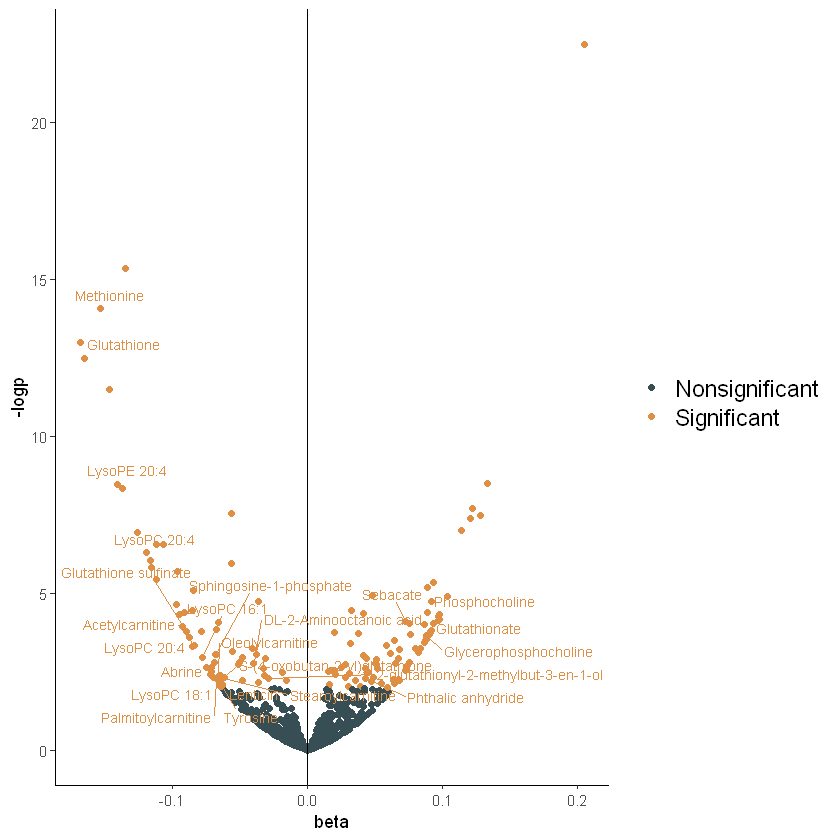

In [15]:
myCol <- get_palette(palette = "jama",12) # customized palette with 12 colors
# Volcano plot where significant metabolites are colored annotations are given when available

volcano_beta <- ggplot(output,aes(x=beta,y=-log(p,base=10),color=significant))+
  geom_point()+
  theme_classic()+
  geom_vline(xintercept = 0)+
  scale_color_jama()+
  geom_text_repel(data=subset(output,significant=="Significant" & Identified==1),
                  aes(label=metabolite_ID),size=3,show.legend = FALSE,max.overlaps = 100)+
  theme(legend.title = element_blank())+
  ylab("-logp")+
  theme(legend.text=element_text(size=14))

volcano_beta

Show temporal trends for the two most significant metabolites with annotations available

`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'


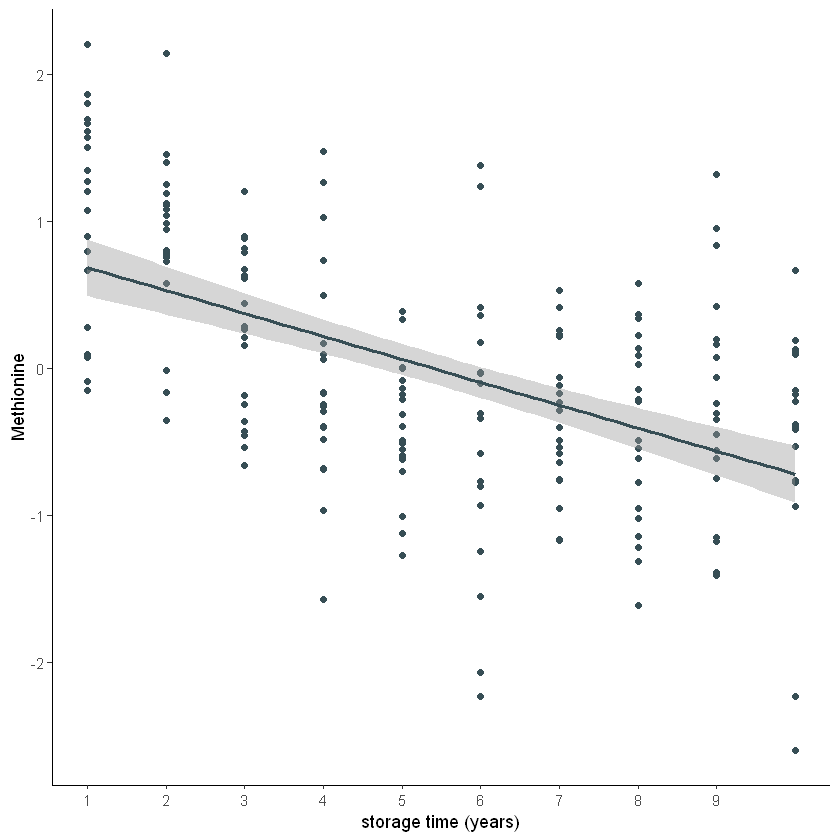

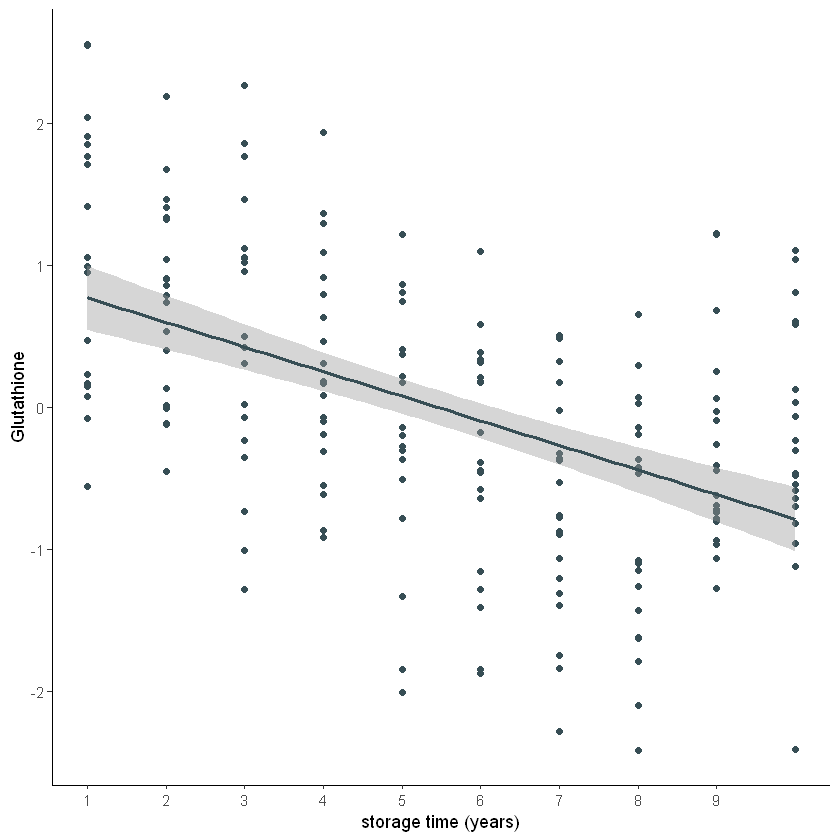

In [16]:
plotMethionine <- ggplot(Data,aes(x=storage,y=Methionine,color=myCol[1]))+
  geom_point()+
  geom_smooth(method = "lm")+
  theme_classic()+
  scale_color_jama()+
  theme(legend.title = element_blank(),legend.position = "none")+
  scale_x_continuous(breaks=seq(0,9,1))+
  xlab("storage time (years)")+
  ylab("Methionine")

plotGlutathione <- ggplot(Data,aes(x=storage,y=Glutathione,color=myCol[1]))+
  geom_point()+
  geom_smooth(method = "lm")+
  theme_classic()+
  scale_color_jama()+
  theme(legend.title = element_blank(),legend.position = "none")+
  scale_x_continuous(breaks=seq(0,9,1))+
  xlab("storage time (years)")+
  ylab("Glutathione")

plotMethionine
plotGlutathione

# Calculate and plot sd-change from baseline

Among significant metabolites, the median for each metabolite and year are calculated.

In [17]:
# Calculate medians for each year
storage_data <- Data[,c(10,start:ncol(Data))] %>% dplyr::group_by(storage) %>% dplyr::summarize_all(.funs = median)
storage_data <- storage_data[,names(storage_data) %in% subset(output,significant=="Significant")$metabolite_ID]
storage_data <- storage_data %>% add_column(storage=1:10,.before = 1)
storage_data

storage,Glutathionate,Acetylcarnitine,Glutathione,57,85,Lenticin,101,130,133,...,4652,4699,4755,4867,5037,5092,5792,6713,6753,8292
1,-0.78295737,0.460590069,0.97328210,0.36256133,-0.77649711,0.323922859,-0.82343777,0.059711910,-0.80903196,...,-0.174793045,0.26268967,-0.20636948,0.169416030,-0.13820823,0.115651223,0.02012133,-0.062602822,0.409352044,0.27657089
2,-0.01336527,-0.014738368,0.82623699,0.01786497,-0.03718223,0.624973611,-0.04719075,0.351313849,0.01735270,...,-0.035202910,-0.02427131,-0.07509037,0.323816082,-0.06547523,0.148891469,-0.11759639,-0.085761531,0.056714245,-0.17864730
3,0.21371674,0.269332622,0.45974780,0.37040647,0.08509546,0.159599443,0.14711162,0.399549648,0.12195967,...,0.102605262,0.09861990,-0.20018273,-0.108422744,-0.10948902,-0.004762914,-0.12300611,0.017128769,0.100167515,0.06853880
4,0.04900609,0.157423959,0.17370519,0.44267959,-0.06247799,-0.060880579,0.03609757,0.195199604,-0.04443934,...,-0.087650651,-0.02569767,-0.06441863,-0.026629692,-0.01839962,-0.001437808,-0.03785969,0.025444822,0.024061778,0.01028937
5,-0.44365432,-0.000858091,0.01761521,-0.01742606,-0.31894355,0.175689523,-0.37168965,0.007596462,-0.31651520,...,-0.090155684,-0.05814929,-0.20202536,-0.025447077,-0.01850396,-0.116804431,-0.01650043,0.009465424,0.052156312,0.05320294
6,0.04381113,-0.158609231,-0.28076729,0.21678963,0.10805737,0.005290669,0.08970886,0.071117007,-0.01647750,...,0.003675929,-0.17922639,0.03022563,-0.184513588,0.01812035,-0.017241602,0.03855782,0.062952326,-0.006363866,0.04086285
7,-0.04745866,-1.018307305,-0.76774446,-0.24270961,-0.05720395,0.121304746,-0.08881923,-0.123660221,-0.19128138,...,0.187559802,-0.09602635,0.13700741,0.003819212,0.20114968,-0.110177422,0.08384518,0.042832690,-0.208712903,-0.03878210
8,0.21254871,-0.187302600,-1.08074544,-0.81329067,0.19491561,-0.194593550,0.17365580,-0.107100395,0.19694657,...,-0.063646795,-0.14392967,0.31732578,-0.125103691,0.06655997,-0.047025839,0.02775353,0.013679096,-0.090821161,0.12643627
9,0.81037327,0.037201440,-0.53068885,-0.05880901,0.78807290,0.145090677,0.73720561,-0.076392191,0.81968708,...,0.021923149,-0.11159451,-0.06571478,-0.404812903,0.01954540,-0.081173160,0.09151846,0.032420777,0.020150630,-0.10649958
10,0.24545850,-0.207954169,-0.38568863,-0.22815310,0.25549627,-0.576451573,0.13895892,-0.132465004,0.26005328,...,0.152176048,-0.10472849,0.06430508,-0.045733898,0.09620530,-0.062673344,-0.01938183,0.060704711,-0.226603638,-0.06817705


Metabolites are first classified as either increasing or decreasing. The average median level within each group is calculated and plotted

In [18]:
# Classify metabolites as increasing or decreasing with storage
pos <- subset(output,beta>0)[,1]
neg <- subset(output,beta<0)[,1]

# Extract temporal trends from previously calculated table
pos_storage <- storage_data[names(storage_data) %in% pos]
neg_storage <- storage_data[names(storage_data) %in% neg]

# For increasing and decreasing featues separately - calculate means relative to year 1
posstoragedata <- cbind.data.frame(storage_data$storage,rowMeans(pos_storage)-rowMeans(pos_storage)[1],
                                   rowMeans(pos_storage)-rowMeans(pos_storage)[1]+rowSds(as.matrix(pos_storage)),
                                   rowMeans(pos_storage)-rowMeans(pos_storage)[1]-rowSds(as.matrix(pos_storage)),
                                   rep("pos",nrow(pos_storage)))
colnames(posstoragedata) <- c("storage","median","high","low","direction")

negstoragedata <- cbind.data.frame(storage_data$storage,rowMeans(neg_storage)-rowMeans(neg_storage)[1],
                                   rowMeans(neg_storage)-rowMeans(neg_storage)[1]+rowSds(as.matrix(neg_storage)),
                                   rowMeans(neg_storage)-rowMeans(neg_storage)[1]-rowSds(as.matrix(neg_storage)),
                                   rep("neg",nrow(pos_storage)))
colnames(negstoragedata) <- colnames(posstoragedata)

# Combine increasing and decreasing features to dataframe for plotting
storagedata <- rbind(posstoragedata,negstoragedata)

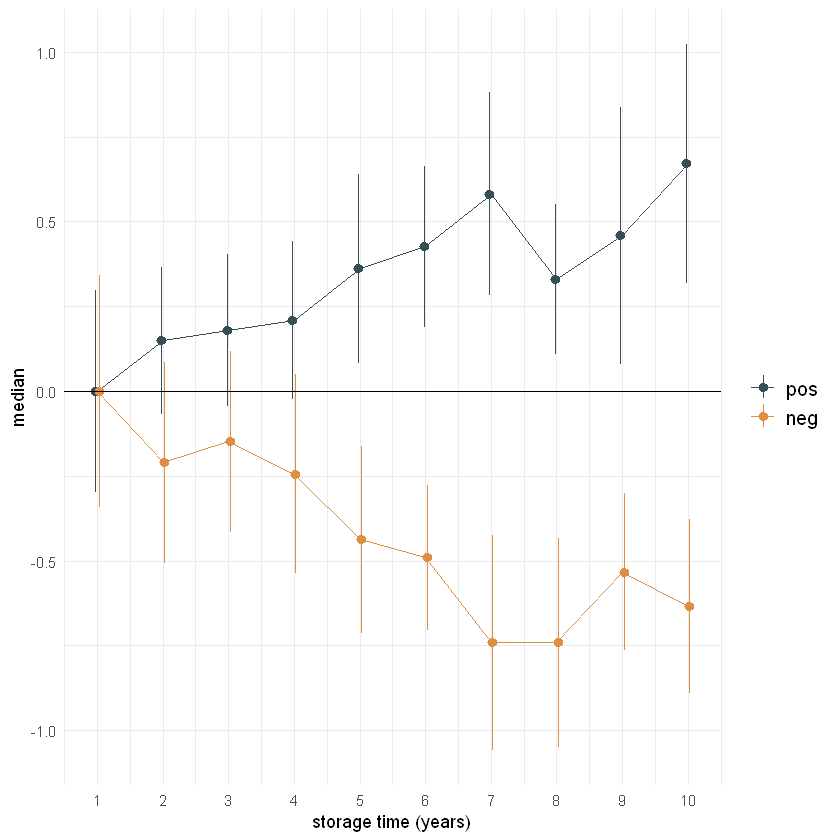

In [19]:
timecourse_plot <- ggplot(storagedata,aes(x=storage,y=median,max=high,min=low,color=direction,fill=direction))+
  geom_line()+
  geom_pointrange(position=position_dodge(0.1))+
  theme_minimal()+
  theme(legend.title = element_blank())+
  geom_hline(aes(yintercept=0))+
  scale_color_jama()+
  scale_fill_jama()+
  scale_x_continuous(breaks=seq(1,10,1))+
  xlab("storage time (years)")+
  theme(legend.text=element_text(size=12))

timecourse_plot

Calculate mean difference between year 1 and 10

In [20]:
rowMeans(pos_storage[10,]-pos_storage[1,])
rowMeans(neg_storage[10,]-neg_storage[1,])

[1] 0.6712289

[1] -0.6349413

# Plot classes in piechart

Display how many significant metabolite features are found in each class

In [21]:
# Calculate how many significant metabolites are in each class
piedata <- cbind.data.frame(output_sig$metabolite_class,rep(1,nrow(output_sig)))
colnames(piedata) <- c("Class","Amount")
piedata <- piedata %>% group_by(Class) %>% summarise(frequency=sum(Amount))


Show number of significant metabolites for each class

In [22]:
piedata
piedata <- subset(piedata,Class!="no matches") # remove metabolite without class annotation

Class,frequency
Acyl carnitines,4
Amino acids and derivatives,17
Glycerophosphocholines,5
Medium-chain fatty acids,1
no matches,106
Peptides,16
Phthalic anhydrides,1
Sugar acids and derivatives,1
Triacylglycerols,1


create piechart

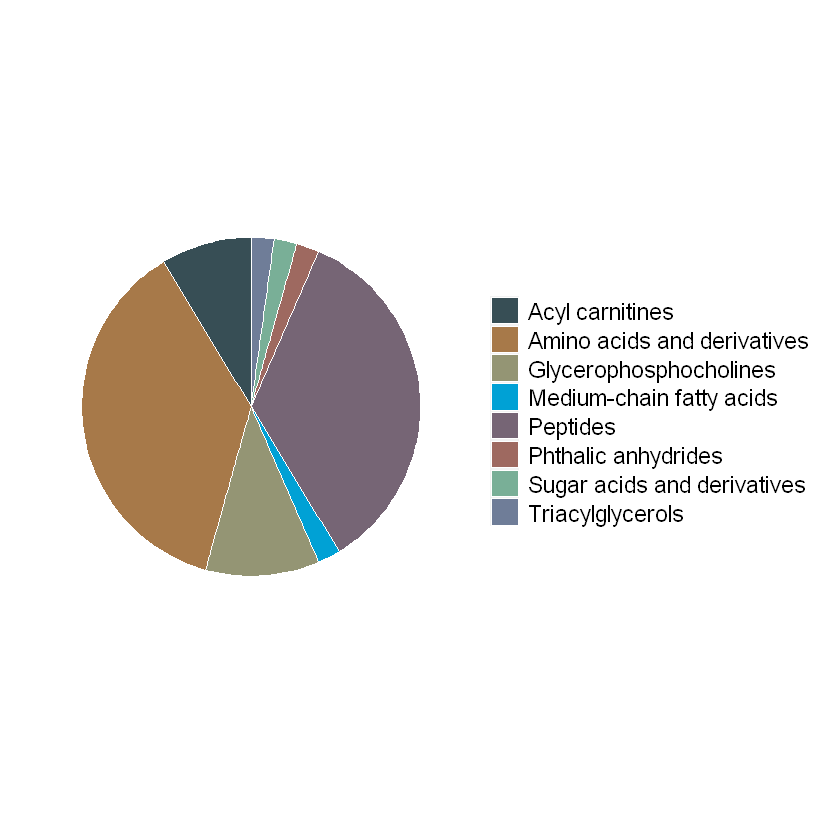

In [23]:
piechar_class <- ggplot(piedata, aes(x="", y=frequency, fill=Class)) +
  geom_bar(stat="identity", width=1, color="white") +
  coord_polar("y", start=0) +
  scale_fill_manual(values=get_palette(palette = "jama",10))+
  xlab("")+
  ylab("")+
  theme(legend.title = element_blank(),panel.background = element_rect(fill="white"),
        legend.position = "right",axis.ticks.y = element_blank(),axis.text.x = element_blank(),
       legend.text=element_text(size=14))

piechar_class

# Plot sd-change from baseline by class

Identify classes with significant metabolites

In [24]:
levels(output_sig$metabolite_class)

[1] ""                            "Acyl carnitines"            
 [3] "Amino acids and derivatives" "Glycerophosphocholines"     
 [5] "Medium-chain fatty acids"    "no matches"                 
 [7] "Peptides"                    "Phthalic anhydrides"        
 [9] "Sugar acids and derivatives" "Triacylglycerols"

In [25]:
# Plot overlayed temporal trends for all significant metabolites within each class
for (i in 1:length(levels(factor(output_sig$metabolite_class)))){
selected_class <- levels(factor(output_sig$metabolite_class))[i] #Define class

# Extract temporal medians for selected class
timecoursedata_class <- storage_data[,names(storage_data) %in% subset(output_sig,metabolite_class==paste(selected_class))$metabolite_ID]
Y1 <- as.data.frame(timecoursedata_class[1,]) # Identify measured metabolite levels after 1 year of storage
corrected <- sapply(1:ncol(timecoursedata_class),function(n){timecoursedata_class[,n]-Y1[,n]}) # Make year 1 baseline

plot_temporal_class <- melt(corrected) %>% # Convert to melted structure
    add_column(storage=rep(1:10,nrow(melt(corrected))*0.1),.before=1) #Add data for storage time
   
# Make one plot for each class
assign(paste("plot",i,sep="_"), ggplot(plot_temporal_class,aes(x=storage,y=value,color=as.factor(L1)))+
  geom_line()+
  theme_classic()+
  geom_point()+
  theme(legend.title = element_blank())+
  geom_hline(aes(yintercept=0))+
  scale_color_manual(values=get_palette(palette = "jama",17))+ # choose palette with 17 layers to cover all metabolites
  scale_x_continuous(breaks=seq(1,10,1))+
  xlab("storage time (years)")+
  ylab("")+
  ggtitle(paste(selected_class))+
  theme(legend.text=element_text(size=14))
)
}    

# Calculate number of metabolites assigned to a class

In [27]:
#number of annotated metabolites
sum(output_sig$metabolite_class!="no matches")
#proportion of annotated metabolites
sum(output_sig$metabolite_class!="no matches")/nrow(output_sig)
#Number of annotated compounds
sum(output_sig$Identified==1)

[1] 46

[1] 0.3026316

[1] 24

# Prepare plots for manuscript

`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
Warning message in grid.Call.graphics(C_polygon, x$x, x$y, index):
"semi-transparency is not supported on this device: reported only once per page"

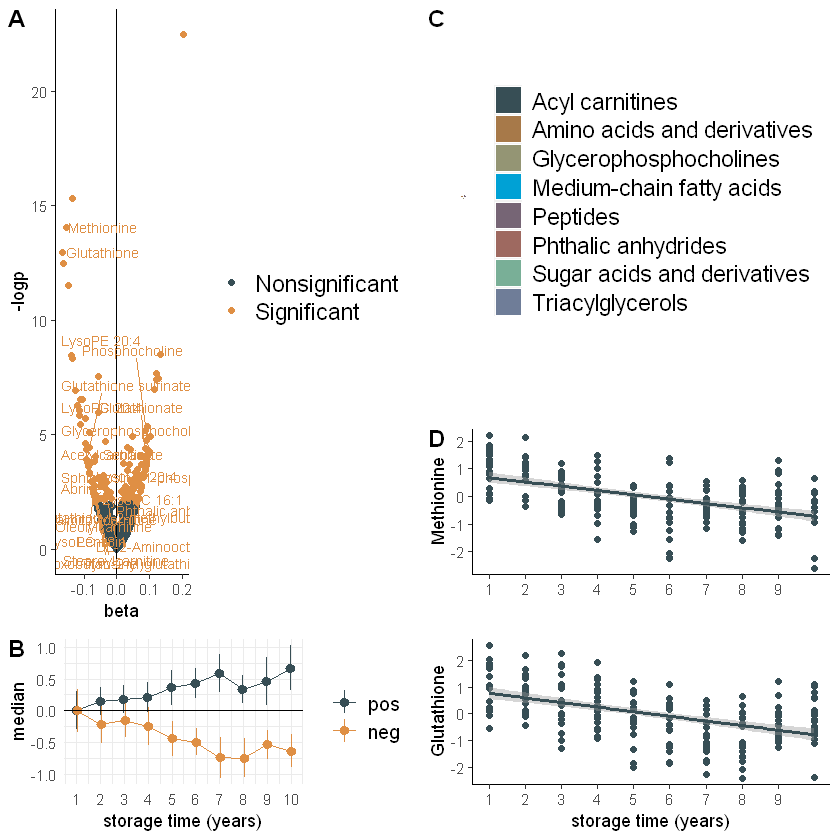

In [28]:
#Export Figure S1
ggsave("G:/Projects/DBS_stability/output/Figure_S1.pdf",pca_plots,width = 16,height = 9)

# Create and export Figure 1
plot_lm <- plot_grid(plot_grid(volcano_beta,timecourse_plot,nrow=2,labels=c("A","B"),rel_heights = c(3,1)),
                     plot_grid(piechar_class,plotMethionine+xlab(""),plotGlutathione,
                                            nrow=3,rel_heights = c(2,1,1),labels=c("C","D","")),
                     ncol=2,labels=c("A",""))
plot_lm
ggsave("G:/Projects/DBS_stability/output/Figure_1.pdf",plot_lm, height = 9, width = 16)
ggsave("G:/Projects/DBS_stability/output/Figure_1.emf",plot_lm, height = 9, width = 16)

# Create and export Figure 2
ggsave("G:/Projects/DBS_stability/output/Figure_2.pdf",plot_grid(plot_1,plot_2,plot_3,plot_6,ncol=2,nrow=2),
       width = 16,height = 9)
ggsave("G:/Projects/DBS_stability/output/Figure_2.pdf",plot_grid(plot_1,plot_2,plot_3,plot_6,ncol=2,nrow=2),
       width = 16,height = 9)

In [29]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 19042)

Matrix products: default

locale:
[1] LC_COLLATE=English_United States.1252 
[2] LC_CTYPE=English_United States.1252   
[3] LC_MONETARY=English_United States.1252
[4] LC_NUMERIC=C                          
[5] LC_TIME=English_United States.1252    

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] ggpubr_0.2.5       magrittr_1.5       matrixStats_0.58.0 ggrepel_0.9.1     
 [5] cowplot_1.1.1      ggsci_2.9          openxlsx_4.2.3     forcats_0.4.0     
 [9] stringr_1.4.0      dplyr_0.8.0.1      purrr_0.3.2        readr_1.3.1       
[13] tidyr_0.8.3        tibble_2.1.1       ggplot2_3.3.5      tidyverse_1.2.1   
[17] data.table_1.12.2 

loaded via a namespace (and not attached):
 [1] httr_1.4.2         splines_3.6.1      jsonlite_1.6       ellipse_0.4.2     
 [5] modelr_0.1.4       assertthat_0.